# 다회용기 분류 모델 학습

## 목표
일회용기 vs 다회용기를 구분하는 이진 분류 모델 학습

## 모델
- **백본**: ResNet50 (ImageNet 사전학습)
- **헤드**: 2-class 분류기
- **출력**: is_reusable (bool), confidence (float)

## 데이터 구조 (새로운 구조)
```
dataset_output/reusable/
├── reusable/     # 다회용기 이미지 (container 영역으로 크롭됨)
├── disposable/   # 일회용기 이미지 (container 영역으로 크롭됨)
└── unclear/      # 불분명한 이미지 (학습에서 제외)
```

**참고**: 데이터는 Label Studio에서 export 후 `convert_labelstudio_to_dataset.py` 스크립트로 생성됨

## 1. 환경 설정

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 2060


## 2. 하이퍼파라미터 설정

In [3]:
# 하이퍼파라미터
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001
IMG_SIZE = 224
NUM_CLASSES = 2  # reusable, disposable

# 경로 (새로운 데이터셋 구조)
# 현재 작업 디렉토리 확인
import os as os_check
print(f"Current working directory: {os_check.getcwd()}")

# 상대 경로로 변경 (노트북은 ai-server/notebooks/ 에 있음)
DATA_DIR = './data/reusable'  # Label Studio에서 변환된 데이터
MODEL_SAVE_PATH = './models/weights/reusable_classifier.pth'

# Train/Val 분할 비율
TRAIN_SPLIT = 0.8

# 클래스 이름
CLASS_NAMES = ['disposable', 'reusable']

print(f"Dataset directory: {DATA_DIR}")
print(f"Absolute path: {os_check.path.abspath(DATA_DIR)}")
print(f"Model will be saved to: {MODEL_SAVE_PATH}")

Current working directory: /app
Dataset directory: ./data/reusable
Absolute path: /app/data/reusable
Model will be saved to: ./models/weights/reusable_classifier.pth


## 3. 데이터 전처리 및 증강

In [4]:
# 학습용 Transform (데이터 증강)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet 통계
])

# 검증용 Transform (증강 없음)
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## 4. 데이터셋 클래스

In [5]:
from sklearn.model_selection import train_test_split

class ReusableDataset(Dataset):
    """다회용기/일회용기 데이터셋 (크롭된 container 이미지)"""
    
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
        print(f"Loaded {len(self.image_paths)} images")
        unique, counts = np.unique(labels, return_counts=True)
        for cls, count in zip(unique, counts):
            print(f"  - {CLASS_NAMES[cls]}: {count}")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # 이미지 로딩
        image = Image.open(img_path).convert('RGB')
        
        # Transform 적용
        if self.transform:
            image = self.transform(image)
        
        return image, label

def load_dataset_from_directory(data_dir, class_names):
    """디렉토리에서 데이터셋 로드 및 Train/Val 분할"""
    all_images = []
    all_labels = []
    
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: {class_dir} not found, skipping...")
            continue
        
        for img_name in os.listdir(class_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_dir, img_name)
                all_images.append(img_path)
                all_labels.append(class_idx)
    
    print(f"\nTotal images loaded: {len(all_images)}")
    print(f"Class distribution:")
    unique, counts = np.unique(all_labels, return_counts=True)
    for cls, count in zip(unique, counts):
        print(f"  - {class_names[cls]}: {count} ({count/len(all_labels)*100:.1f}%)")
    
    # Train/Val 분할 (stratified)
    train_images, val_images, train_labels, val_labels = train_test_split(
        all_images, all_labels, 
        test_size=1-TRAIN_SPLIT, 
        stratify=all_labels,
        random_state=42
    )
    
    print(f"\nSplit: {len(train_images)} train, {len(val_images)} val")
    
    return train_images, val_images, train_labels, val_labels

## 5. 데이터 로더 생성

In [8]:
# 데이터 로드 및 분할
train_images, val_images, train_labels, val_labels = load_dataset_from_directory(DATA_DIR, CLASS_NAMES)

# 데이터셋 생성
train_dataset = ReusableDataset(train_images, train_labels, transform=train_transform)
val_dataset = ReusableDataset(val_images, val_labels, transform=val_transform)

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")


Total images loaded: 220
Class distribution:
  - disposable: 78 (35.5%)
  - reusable: 142 (64.5%)

Split: 176 train, 44 val
Loaded 176 images
  - disposable: 62
  - reusable: 114
Loaded 44 images
  - disposable: 16
  - reusable: 28

Train batches: 6
Val batches: 2


# 데이터 로드 및 분할
train_images, val_images, train_labels, val_labels = load_dataset_from_directory(DATA_DIR, CLASS_NAMES)

# 데이터셋 생성
train_dataset = ReusableDataset(train_images, train_labels, transform=train_transform)
val_dataset = ReusableDataset(val_images, val_labels, transform=val_transform)

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

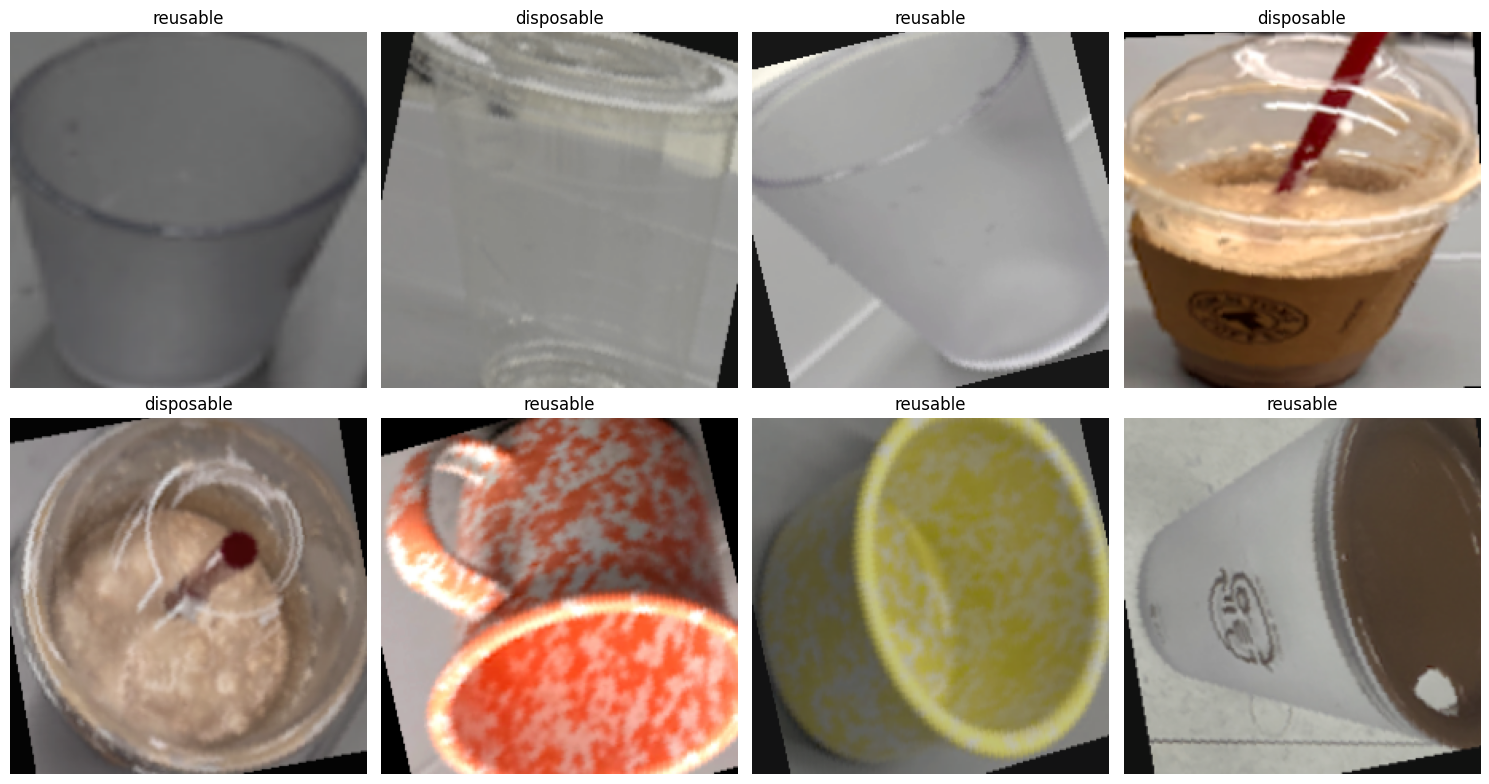

In [9]:
# 샘플 이미지 확인
def show_samples(loader, num_samples=8):
    images, labels = next(iter(loader))
    
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.flatten()
    
    for i in range(min(num_samples, len(images))):
        img = images[i].permute(1, 2, 0).numpy()
        # Denormalize
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(CLASS_NAMES[labels[i]])
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

show_samples(train_loader)

## 7. 모델 정의

In [10]:
class ReusableClassifier(nn.Module):
    """ResNet50 기반 다회용기 분류기"""
    
    def __init__(self, num_classes=2, pretrained=True):
        super(ReusableClassifier, self).__init__()
        
        # ResNet50 백본 (ImageNet 사전학습)
        self.backbone = models.resnet50(pretrained=pretrained)
        
        # 분류 헤드 교체
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

# 모델 생성
model = ReusableClassifier(num_classes=NUM_CLASSES, pretrained=True)
model = model.to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 45.9MB/s]


Model parameters: 24,558,146


## 8. 손실 함수 및 옵티마이저

In [11]:
# 손실 함수 (Cross Entropy)
criterion = nn.CrossEntropyLoss()

# 옵티마이저 (Adam)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 학습률 스케줄러 (ReduceLROnPlateau)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

## 9. 학습 및 평가 함수

In [12]:
def train_epoch(model, loader, criterion, optimizer, device):
    """1 에폭 학습"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # Forward
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward
        loss.backward()
        optimizer.step()
        
        # 통계
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    """검증"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * accuracy_score(all_labels, all_preds)
    
    return epoch_loss, epoch_acc, all_preds, all_labels

## 10. 학습 실행

In [13]:
# 학습 히스토리
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 50)
    
    # 학습
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # 검증
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
    
    # 히스토리 저장
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # 학습률 스케줄러
    scheduler.step(val_loss)
    
    # 최고 모델 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"✓ Best model saved (Val Acc: {val_acc:.2f}%)")

print(f"\n{'='*50}")
print(f"Training completed! Best Val Acc: {best_val_acc:.2f}%")


Epoch 1/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.01it/s]


Train Loss: 1.0628, Train Acc: 55.11%
Val Loss: 19.9328, Val Acc: 63.64%
✓ Best model saved (Val Acc: 63.64%)

Epoch 2/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.93it/s]


Train Loss: 0.5070, Train Acc: 68.18%
Val Loss: 1.6238, Val Acc: 72.73%
✓ Best model saved (Val Acc: 72.73%)

Epoch 3/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.59it/s]


Train Loss: 0.3187, Train Acc: 94.89%
Val Loss: 1.3431, Val Acc: 40.91%

Epoch 4/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.08it/s]


Train Loss: 0.4382, Train Acc: 83.52%
Val Loss: 0.4879, Val Acc: 77.27%
✓ Best model saved (Val Acc: 77.27%)

Epoch 5/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.84it/s]


Train Loss: 0.2292, Train Acc: 89.20%
Val Loss: 1.0653, Val Acc: 70.45%

Epoch 6/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]


Train Loss: 0.1459, Train Acc: 94.32%
Val Loss: 0.1275, Val Acc: 93.18%
✓ Best model saved (Val Acc: 93.18%)

Epoch 7/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.02it/s]


Train Loss: 0.2279, Train Acc: 93.18%
Val Loss: 3.9173, Val Acc: 63.64%

Epoch 8/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.65it/s]


Train Loss: 0.1602, Train Acc: 94.89%
Val Loss: 0.1813, Val Acc: 93.18%

Epoch 9/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.03it/s]


Train Loss: 0.1297, Train Acc: 94.89%
Val Loss: 0.1682, Val Acc: 95.45%
✓ Best model saved (Val Acc: 95.45%)

Epoch 10/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.73it/s]


Train Loss: 0.0949, Train Acc: 97.16%
Val Loss: 0.1242, Val Acc: 95.45%

Epoch 11/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]


Train Loss: 0.1123, Train Acc: 96.02%
Val Loss: 0.0544, Val Acc: 97.73%
✓ Best model saved (Val Acc: 97.73%)

Epoch 12/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.95it/s]


Train Loss: 0.0613, Train Acc: 97.16%
Val Loss: 0.0069, Val Acc: 100.00%
✓ Best model saved (Val Acc: 100.00%)

Epoch 13/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.79it/s]


Train Loss: 0.1752, Train Acc: 94.89%
Val Loss: 0.4114, Val Acc: 90.91%

Epoch 14/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.78it/s]


Train Loss: 0.0838, Train Acc: 97.73%
Val Loss: 0.0401, Val Acc: 97.73%

Epoch 15/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.84it/s]


Train Loss: 0.0737, Train Acc: 97.73%
Val Loss: 0.0713, Val Acc: 95.45%

Epoch 16/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.86it/s]


Train Loss: 0.0924, Train Acc: 97.16%
Val Loss: 0.0357, Val Acc: 100.00%
Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.

Epoch 17/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.87it/s]


Train Loss: 0.1522, Train Acc: 97.16%
Val Loss: 0.0489, Val Acc: 97.73%

Epoch 18/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.00it/s]


Train Loss: 0.0470, Train Acc: 98.86%
Val Loss: 0.0504, Val Acc: 97.73%

Epoch 19/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.02it/s]


Train Loss: 0.0952, Train Acc: 97.16%
Val Loss: 0.0414, Val Acc: 97.73%

Epoch 20/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]


Train Loss: 0.0835, Train Acc: 97.16%
Val Loss: 0.0069, Val Acc: 100.00%
Epoch 00020: reducing learning rate of group 0 to 2.5000e-04.

Training completed! Best Val Acc: 100.00%


## 11. 학습 곡선 시각화

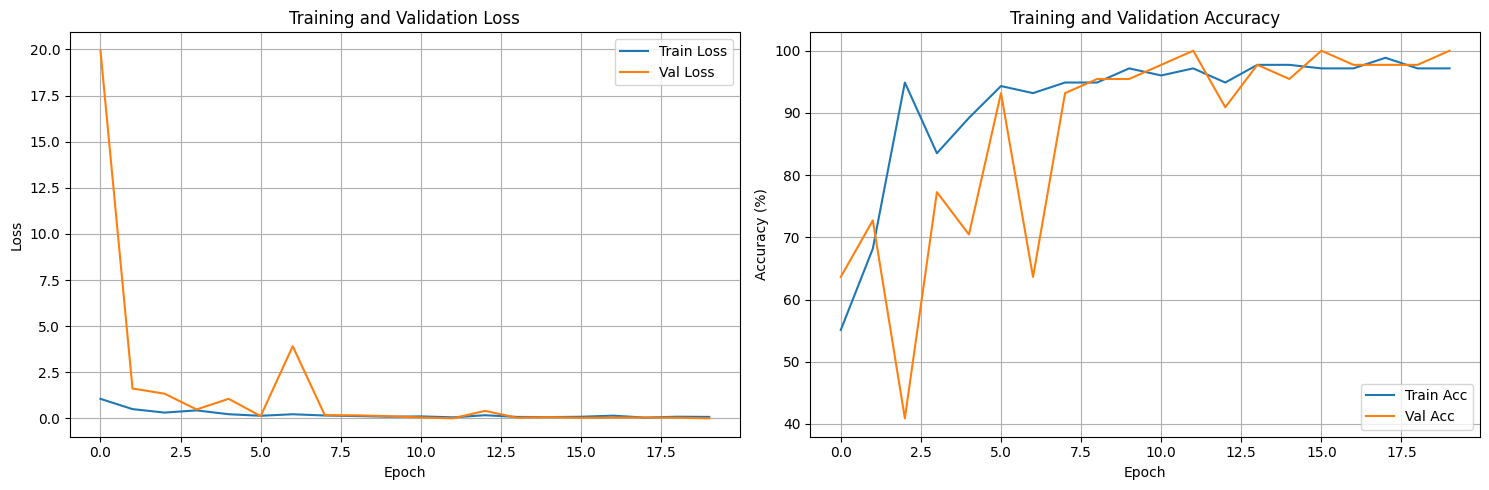

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy
ax2.plot(history['train_acc'], label='Train Acc')
ax2.plot(history['val_acc'], label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 12. 최종 평가

In [15]:
# 최고 모델 로드
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()

# 검증 세트 평가
val_loss, val_acc, preds, labels = validate(model, val_loader, criterion, device)

print(f"Final Validation Accuracy: {val_acc:.2f}%")
print(f"Final Validation Loss: {val_loss:.4f}")

Validation: 100%|██████████| 2/2 [00:00<00:00,  7.96it/s]

Final Validation Accuracy: 100.00%
Final Validation Loss: 0.0069


## 13. Confusion Matrix

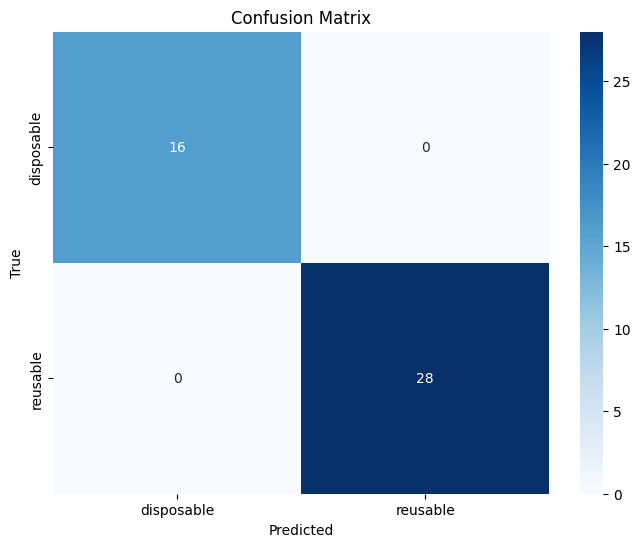


Classification Report:
              precision    recall  f1-score   support

  disposable       1.00      1.00      1.00        16
    reusable       1.00      1.00      1.00        28

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44



In [16]:
# Confusion Matrix
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=CLASS_NAMES))

## 14. 추론 함수

In [17]:
def predict_image(model, image_path, transform, device):
    """단일 이미지 예측"""
    model.eval()
    
    # 이미지 로딩 및 전처리
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # 예측
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    is_reusable = predicted.item() == 1
    confidence_score = confidence.item()
    
    return {
        'is_reusable': is_reusable,
        'confidence': confidence_score,
        'class': CLASS_NAMES[predicted.item()],
        'probabilities': probabilities.cpu().numpy()[0]
    }

def visualize_prediction(image_path, result):
    """예측 결과 시각화"""
    image = Image.open(image_path)
    
    plt.figure(figsize=(10, 5))
    
    # 이미지
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediction: {result['class']}\nConfidence: {result['confidence']*100:.1f}%")
    
    # 확률 분포
    plt.subplot(1, 2, 2)
    plt.bar(CLASS_NAMES, result['probabilities'])
    plt.ylabel('Probability')
    plt.title('Class Probabilities')
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

## 15. 테스트 이미지로 추론

Image: zf_bottle_129.png
Is Reusable: True
Confidence: 99.87%
Class: reusable
Probabilities: Disposable=0.001, Reusable=0.999


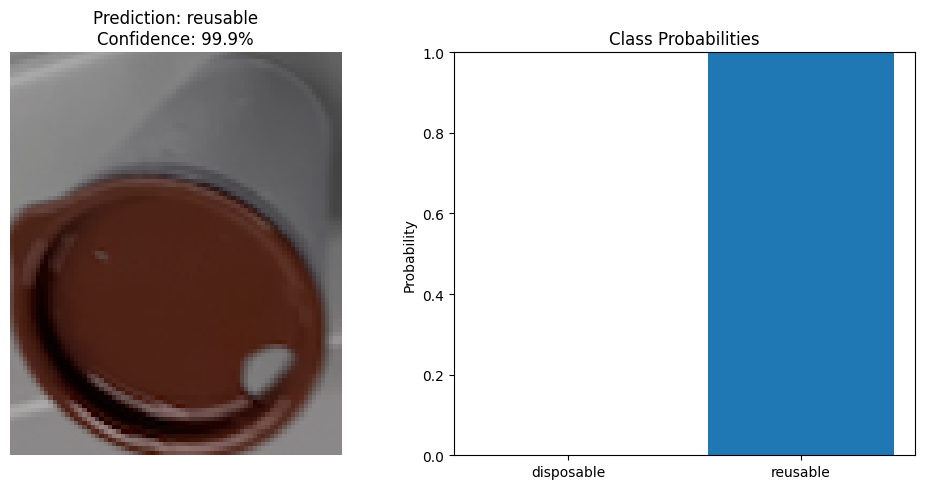

In [22]:
# 검증 세트에서 랜덤 샘플 선택
import random

# 랜덤 샘플 선택
test_image_path = random.choice(val_images)

# 예측
result = predict_image(model, test_image_path, val_transform, device)

# 결과 출력
print(f"Image: {os.path.basename(test_image_path)}")
print(f"Is Reusable: {result['is_reusable']}")
print(f"Confidence: {result['confidence']*100:.2f}%")
print(f"Class: {result['class']}")
print(f"Probabilities: Disposable={result['probabilities'][0]:.3f}, Reusable={result['probabilities'][1]:.3f}")

# 시각화
visualize_prediction(test_image_path, result)

## 16. 모델 저장 (ONNX 포맷, 선택사항)

In [19]:
# ONNX로 변환 (추론 최적화용)
dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
onnx_path = MODEL_SAVE_PATH.replace('.pth', '.onnx')

torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    export_params=True,
    opset_version=11,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)

print(f"Model exported to ONNX: {onnx_path}")

Model exported to ONNX: ./models/weights/reusable_classifier.onnx


## 요약

### 학습된 모델
- **모델 파일**: `../models/weights/classifier.pth`
- **최고 검증 정확도**: {best_val_acc:.2f}%

### 다음 단계
1. FastAPI 서버에 모델 통합
2. 실전 데이터로 추가 테스트
3. 오분류 케이스 분석 및 데이터 보강